In [1]:
!pip install skforecast
!pip install statsmodels

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

## Problema final vs problema local
Hay que tener en cuenta en este tipo de concursos la diferencia entre el problema final y el problema local, o subproblema, que utilizamos para simular que tenemos acceso al problema completo.

**Problema final**: predicción del consumo de agua por días de diferentes contadores distribuidos en la Comunidad Valencia. Problema para evaluarlo: solo tenemos acceso a dos evaluaciones por cada entrega y el número de entregas es reducida.
**Problema local**: vamos a coger un subconjunto de datos reducido para poder evaluar el desempeño de distintas combinaciones de algoritmos y procesamientos que queramos probar, evaluar su desempeño y finalmente, elegir los mejores para aplicarlos al problema final. Es interesante tque este problema local sea lo más similar posible al problema final

Tengamos en cuenta que pueden darse situaciones en las que se nos den resultados inesperados, por ejemplo que un algoritmo que ha desempeñado peor en nuestro problema local, nos de un mejor resultado que en la entrega final. A esto lo podemos llamar **error de correlación**, se puede dar porque al final el problema local no es igual al problema final aunque intentemos simularlo, debido puede ser interesante que en una primera instancia hagamos entregas de cosas muy diferentes, pero que consideemos que pueden ser interesantes, para validar que hemos seleccionado bien el subproblema o por donde puede estar más claro.

In [3]:
water_consumptions = pd.read_csv('./data/water_consumptions_100.csv')
print(water_consumptions.dtypes)
water_consumptions.head()

id              int64
datetime       object
consumption     int64
dtype: object


,id,datetime,consumption
0,0,2019-02-01,243
1,0,2019-02-02,236
2,0,2019-02-03,335
3,0,2019-02-04,252
4,0,2019-02-05,220


In [4]:
water_consumptions['datetime'] = water_consumptions['datetime'].apply(pd.to_datetime)
water_consumptions.dtypes

id                      int64
datetime       datetime64[ns]
consumption             int64
dtype: object

## Preparación de los datos

En esta primera etapa, vamos a preparar los datos para que puedan ser usados fácilmente para preprocesarlos, ingeniería de características, entrenamiento, predicción y evaluación. Esta etapa es común tanto para el problema final como el local, y es importante dedicarle algo de tiempo porque nos va a facilitar el resto de etapas.

En est caso como ya tenemos los dataframe con las series temporales para entrenar y predecir, en este apartado hemos hecho algunas transformaciones para obtener un diccionario de id-serie_temporal que nos va a ser útil a la hora de crear los clusters más adelante.


In [5]:
N_DAYS_YEAR = 365

id_length = water_consumptions.groupby(['id']).size()
print('Number of series:', len(id_length))
complete_series_ids = id_length[id_length == N_DAYS_YEAR]
complete_series_ids = complete_series_ids.to_frame().reset_index()
print('Number of complete series: ', len(complete_series_ids))

Number of series: 101
Number of complete series:  81


In [6]:
complete_series_df = water_consumptions[water_consumptions['id'].isin(complete_series_ids['id'])]
complete_series_df

,id,datetime,consumption
0,0,2019-02-01,243
1,0,2019-02-02,236
2,0,2019-02-03,335
3,0,2019-02-04,252
4,0,2019-02-05,220
...,...,...,...
35589,100,2020-01-27,471
35590,100,2020-01-28,445
35591,100,2020-01-29,720
35592,100,2020-01-30,402


In [7]:
consumption_series = dict()

for id_serie in set(complete_series_df['id']):
  id_df = complete_series_df[complete_series_df['id'] == id_serie]
  date_consumption_df = id_df.loc[:,["datetime","consumption"]]
  date_consumption_df.set_index("datetime",inplace=True)
  date_consumption_df.sort_index(inplace=True)
  consumption_series[id_serie] = date_consumption_df

## Preprocesamiento

La clusterización es un algoritmo que es sensible a la magnitud de las características, con lo cual, decidimos aplicar un preprocesamiento a las series temporales en forma de estandarización en nuestro caso. Este tipo de preprocesamiento, lo aplicaremos más adelanta también en las etapas de entrenamiento y predicción, para las variables de entrada a los modelos.

El preprocesamiento de los datos puede ser tan importante, o incluso más, que el propio modelo o algoritmo. Es muy importante saber con el tipo de modelo que estamos trabajando y qué preprocesamiento es necesario para que funcione de forma normal, o para mejorar su desempeño. 
Algunos de los métodos más fáciles de utilizar, debido a que se usan comúnmente son:
- Escalado:
- Normalización:
- Estandarización:

Un preprocesamiento básico puede darnos una gran sorpresa.

In [8]:
from sklearn.preprocessing import StandardScaler

for index in consumption_series:
    scaler = StandardScaler()
    consumption_series[index] = scaler.fit_transform(consumption_series[index])
    consumption_series[index] = consumption_series[index].reshape(len(consumption_series[index]))
    
water_series_anonimized = list(consumption_series.values())
water_series_anonimized[0]

array([-3.72417048e-01, -4.37922043e-01,  4.88505743e-01, -2.88196340e-01,
       -5.87647745e-01, -6.36077857e-02, -5.42499293e-02, -8.40309869e-01,
       -1.94617776e-01,  3.01348615e-01, -5.50216320e-01,  5.07221456e-01,
       -5.97005602e-01, -1.75902063e-01,  9.47040708e-01, -3.55342164e-02,
        5.63368595e-01,  3.48137897e-01,  1.19034498e+00, -2.22691345e-01,
        2.82632902e-01,  9.18967139e-01, -5.68932033e-01,  6.75662872e-01,
        9.37682852e-01, -3.25627766e-01,  2.91990758e-01, -9.61962002e-01,
       -6.99942023e-01, -4.94069181e-01,  6.66305015e-01,  3.57495753e-01,
        3.38780040e-01,  1.89054338e-01, -3.72417048e-01, -1.38306554e+00,
       -1.57186350e-01,  1.31199711e+00,  2.45365559e+00, -5.87647745e-01,
       -6.90584166e-01,  1.80796350e+00,  3.85569323e-01,  2.99707785e-02,
       -5.40858463e-01, -6.43794884e-01,  1.15291355e+00,  1.12550657e-02,
        9.09609282e-01, -8.77741295e-01,  9.54757735e-02,  9.47040708e-01,
       -5.12784894e-01, -

## Clusterización

Tenemos un problema de predicción de consumo de agua por contadores. En este caso se puede dar que distintos contadores tengan comportamiento muy diferente, mientras que otros se puedan generalizar con el mismo patrón. Con lo cual aplicar una clusterización sobre estos contadores es interesante para aplicar distintos modelos a los distintos patrones de comportamiento.

En este caso aplicamos la clusterización sobre el problema completo. ¿Porqué es esto? Porque de esta manera los clusters que usemos en nuestro problema local, van a ser los mismos que aquellos que usaremos en el momento de la entrega. En casto contrario, podríamos provocar los mencionados problemas de correlación.

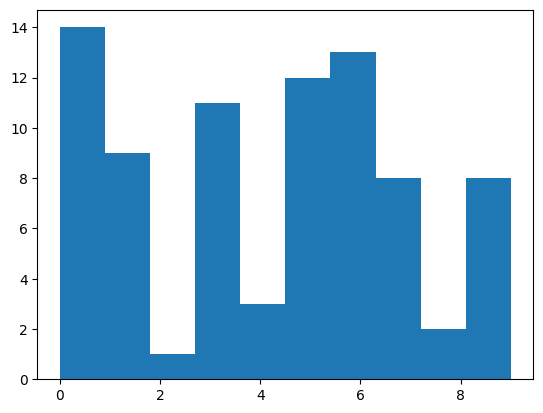

In [9]:
OPTIMAL_NUMBER_CLUSTERS = 10
SEED = 10

k_means = KMeans(n_clusters=OPTIMAL_NUMBER_CLUSTERS, random_state=SEED)
k_means.fit(water_series_anonimized)
cluster_labels = k_means.labels_

y, x, _ = plt.hist(cluster_labels)

In [10]:
id_cluster = dict()
for index in consumption_series:
    predicted = k_means.predict([consumption_series[index]])
    id_cluster[index] = predicted[0]
id_cluster

{0: 6,
 1: 6,
 2: 3,
 3: 7,
 4: 3,
 5: 9,
 6: 1,
 7: 6,
 8: 1,
 9: 9,
 10: 1,
 12: 5,
 13: 0,
 14: 5,
 15: 1,
 16: 0,
 17: 9,
 18: 3,
 19: 5,
 20: 0,
 21: 8,
 22: 7,
 24: 3,
 25: 6,
 27: 3,
 28: 7,
 29: 5,
 30: 3,
 31: 3,
 36: 5,
 38: 0,
 40: 0,
 41: 4,
 42: 5,
 43: 0,
 44: 6,
 45: 6,
 46: 6,
 47: 9,
 48: 3,
 49: 4,
 50: 7,
 51: 1,
 52: 5,
 53: 5,
 55: 9,
 56: 1,
 57: 9,
 58: 2,
 59: 0,
 60: 1,
 61: 6,
 63: 7,
 65: 5,
 66: 0,
 68: 6,
 69: 6,
 70: 1,
 71: 7,
 75: 4,
 77: 6,
 80: 3,
 81: 3,
 82: 0,
 83: 7,
 84: 1,
 86: 5,
 87: 8,
 88: 0,
 89: 0,
 90: 6,
 91: 6,
 92: 9,
 93: 9,
 94: 5,
 95: 0,
 96: 3,
 97: 5,
 98: 0,
 99: 0,
 100: 7}

In [11]:
UNCOMPLETE_SERIE_CLUSTER = 10

def assign_cluster_or_default(id, id_clusters):
  if id in id_clusters.keys():
    return id_clusters[id]
  else:
    return UNCOMPLETE_SERIE_CLUSTER

In [12]:
water_consumptions['cluster'] = water_consumptions.apply(lambda row: assign_cluster_or_default(row.id, id_cluster), axis = 1)
water_consumptions

,id,datetime,consumption,cluster
0,0,2019-02-01,243,6
1,0,2019-02-02,236,6
2,0,2019-02-03,335,6
3,0,2019-02-04,252,6
4,0,2019-02-05,220,6
...,...,...,...,...
35589,100,2020-01-27,471,7
35590,100,2020-01-28,445,7
35591,100,2020-01-29,720,7
35592,100,2020-01-30,402,7


## Separación entrenamiento-predicción (Creación del subproblema)

En el problema final, tenemos que predecir dos semanas de consumo diario para cada uno de los contadores; en nuestro subproblema, vamos a hacerlo de la misma manera. Del total de conjunto de datos que tenemos, vamos a seleccionar las últimas dos semanas [2020-01-17 / 2020-01-31] para predicción y evaluación, y el restante [2019-02-01 / 2020-01-16] para entrenamiento.

In [13]:
print('Datatime range:', min(water_consumptions['datetime']) ,max(water_consumptions['datetime']))

Datatime range: 2019-02-01 00:00:00 2020-01-31 00:00:00


In [14]:
def train_test_split(water_consumptions):
    train =  water_consumptions.loc[water_consumptions['datetime'] < datetime(2020, 1, 18)]
    test = water_consumptions.loc[water_consumptions['datetime'] >= datetime(2020, 1, 18)]
    return train, test

In [15]:
train_df, test_df = train_test_split(water_consumptions)
print('train datatime range:', min(train_df['datetime']) ,max(train_df['datetime']))
print('test datatime range:', min(test_df['datetime']) ,max(test_df['datetime']))

Train shape: (34193, 4)
Test shape: (1401, 4)


## Obtención de los mejores parámetros para el modelo

En un problema de predicción, aplicar los parámetros correctos al modelo pueden ser una mejora importante en el comportamiento del mismo para el problema, este este caso para la serie temporal. Es importante aplicar algún tipo de búsqueda sobre la misma para de esta manera aprovecharse de ello. Aquí podemos ver una implementación customizada para el algoritmo SARIMA. En otro problema, podemos utilizar una implementación de Scikit-Learn, Optuna, o cualquier otro algoritmo para el tunning de parámetros.

In [16]:
import itertools
import statsmodels.api as sm

def sarima_grid_search(y, seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal
            except:
                continue
    return {
        'order': param_mini,
        'seasonal_order': param_seasonal_mini,
        'enforce_stationarity': False,
        'enforce_invertibility': False
    }
     

Debido a la magnitud del problema, no podemos hacer una obtención de los mejores parámetros para cada una de las series temporales individuales, es por ello que nos aprovechamos de la clusterización anterior al obtener los mejores parámetros para cada serie en base a su comportamiento clusterizado y mitigando el ruido de cada una de ellas por separado, recordemos que nos interesa el comportamiento general.


In [17]:
def cluster_grouped_ts(dataset, cluster_id) -> pd.DataFrame:
  cluster_series = dataset[dataset['cluster'] == cluster_id]
  cluster_series.drop(['id','cluster'], axis = 1, inplace = True)
  return cluster_series.groupby('datetime').sum()

def grid_search_by_cluster(dataset, seasonal_period=30) -> dict:
  best_params_per_cluster = {}
  for cluster_id in set(dataset.cluster):
    cluster_ts = cluster_grouped_ts(dataset, cluster_id)
    best_params_cluster = sarima_grid_search(cluster_ts, seasonal_period)
    best_params_per_cluster[cluster_id] = best_params_cluster
  return best_params_per_cluster

## Entrenamiento y predicción

Finalmente, juntamos todo lo anterior para realizar el entrenamiento y predicción para cada una de las series, aprovechando los parámetros obtenidos en esa gridsearch por cluster.
Aquí tenemos un caso en el que el nivel de parametrización tratamos de llevarlo más avanzado, dando la posibilidad de aplicar incluso distintos algoritmos y parametrizaciones entre clusters.

In [18]:
def generate_append_from_predictions(predicted, ts_id):
  week_1 = sum(predicted[:7])
  week_2 = sum(predicted[7:])
  days_week_consumptions = np.append(np.append(predicted[:7], week_1), week_2)
  return np.concatenate(([ts_id],days_week_consumptions))
  

def train_predict_by_id(train_dataset, model_per_cluster, params_per_cluster, scaler_per_cluster, default_model, default_params, default_scaler, predict_steps=14):
  column_names = ['id', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'day_7', 'week_1', 'week_2']
  df = pd.DataFrame(columns = column_names)
  ids = set(train_dataset['id'])
  for ts_id in ids:
    try:
      print('id: {id} de {len}, completado: {percent:.2f}%'.format(id=ts_id, len=len(ids), percent=(len(df)/len(ids))*100))
      current_id_time_serie = train_dataset[train_dataset['id'] == ts_id]
      cluster = list(current_id_time_serie['cluster'])[0]
      print('Cluster:', cluster)

      if cluster < UNCOMPLETE_SERIE_CLUSTER and model_per_cluster is not None:
        params = params_per_cluster[cluster]
        scaler = scaler_per_cluster[cluster]()
        model = model_per_cluster[cluster](**params, scaler=scaler)
      else:
        scaler = default_scaler()
        model = default_model(**default_params, scaler=scaler)

      model.train(current_id_time_serie)
      predicted = model.predict(predict_steps)
      to_append = generate_append_from_predictions(predicted, ts_id)
    
    except Exception as e:
      print(e)
      to_append = [ts_id, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    df.loc[len(df)] = to_append
  return df

Un ejemplo de ejecución es el siguiente:
1. Seleccionamos modelo, scaler y parámetros para las series que no tengan cluster (series incompletas)
2. Creamos un diccionario para los parámetros de los modelos que queremos ejecutar para cada uno de los clusters
3. Creamos un diccionario para los modelos que vamos a utilizar
4. Seleccionamos los scalers que queremos probar.
5. Ejecutamos el train-predict

In [19]:
from models.sarima_model import SarimaModel
from models.autoreg_model import AutoregModel
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


default_sarima_params = {
    'order': (1, 1, 1),
    'seasonal_order': (1, 1, 1, 30),
    'enforce_stationarity': False,
    'enforce_invertibility': False
}
default_model = SarimaModel
default_scaler = StandardScaler
# params_by_cluster = grid_search_by_cluster(train_df)
autoreg_params = {
    'regressor': RandomForestRegressor
}

params_by_cluster = {
    0: default_sarima_params,
    1: autoreg_params,
    2: autoreg_params,
    3: autoreg_params,
    4: autoreg_params,
    5: autoreg_params,
    6: autoreg_params,
    7: autoreg_params,
    8: autoreg_params,
    9: autoreg_params,
    10: autoreg_params
}
models_by_cluer = {
    0: SarimaModel,
    1: AutoregModel,
    2: AutoregModel,
    3: AutoregModel,
    4: AutoregModel,
    5: AutoregModel,
    6: AutoregModel,
    7: AutoregModel,
    8: AutoregModel,
    9: AutoregModel,
    10: AutoregModel
}
scaler_by_cluster = {
    0: StandardScaler,
    1: StandardScaler,
    2: StandardScaler,
    3: StandardScaler,
    4: StandardScaler,
    5: StandardScaler,
    6: StandardScaler,
    7: StandardScaler,
    8: StandardScaler,
    9: StandardScaler,
    10: StandardScaler
}

In [20]:
predictions = train_predict_by_id(train_df, None, None, None, default_model=default_model, default_params=default_sarima_params, default_scaler=default_scaler, predict_steps=14)
predictions.head()

id: 0 de 101, completado: 0.00%
Cluster: 6


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


id: 1 de 101, completado: 0.99%
Cluster: 6
id: 2 de 101, completado: 1.98%
Cluster: 3
id: 3 de 101, completado: 2.97%
Cluster: 7
id: 4 de 101, completado: 3.96%
Cluster: 3
id: 5 de 101, completado: 4.95%
Cluster: 9
id: 6 de 101, completado: 5.94%
Cluster: 1
id: 7 de 101, completado: 6.93%
Cluster: 6
id: 8 de 101, completado: 7.92%
Cluster: 1
id: 9 de 101, completado: 8.91%
Cluster: 9
id: 10 de 101, completado: 9.90%
Cluster: 1
id: 11 de 101, completado: 10.89%
Cluster: 10


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


id: 12 de 101, completado: 11.88%
Cluster: 5


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/numpy/lib/function_base.py:5438: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(arr)


id: 13 de 101, completado: 12.87%
Cluster: 0
id: 14 de 101, completado: 13.86%
Cluster: 5
id: 15 de 101, completado: 14.85%
Cluster: 1
id: 16 de 101, completado: 15.84%
Cluster: 0


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


id: 17 de 101, completado: 16.83%
Cluster: 9
id: 18 de 101, completado: 17.82%
Cluster: 3
id: 19 de 101, completado: 18.81%
Cluster: 5
id: 20 de 101, completado: 19.80%
Cluster: 0
id: 21 de 101, completado: 20.79%
Cluster: 8
id: 22 de 101, completado: 21.78%
Cluster: 7
id: 23 de 101, completado: 22.77%
Cluster: 10
id: 24 de 101, completado: 23.76%
Cluster: 3
id: 25 de 101, completado: 24.75%
Cluster: 6
id: 26 de 101, completado: 25.74%
Cluster: 10
id: 27 de 101, completado: 26.73%
Cluster: 3
id: 28 de 101, completado: 27.72%
Cluster: 7
id: 29 de 101, completado: 28.71%
Cluster: 5
id: 30 de 101, completado: 29.70%
Cluster: 3
id: 31 de 101, completado: 30.69%
Cluster: 3
id: 32 de 101, completado: 31.68%
Cluster: 10
id: 33 de 101, completado: 32.67%
Cluster: 10
id: 34 de 101, completado: 33.66%
Cluster: 10
id: 35 de 101, completado: 34.65%
Cluster: 10
id: 36 de 101, completado: 35.64%
Cluster: 5
id: 37 de 101, completado: 36.63%
Cluster: 10
id: 38 de 101, completado: 37.62%
Cluster: 0
id:

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


id: 41 de 101, completado: 40.59%
Cluster: 4


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


id: 42 de 101, completado: 41.58%
Cluster: 5


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


id: 43 de 101, completado: 42.57%
Cluster: 0
id: 44 de 101, completado: 43.56%
Cluster: 6
id: 45 de 101, completado: 44.55%
Cluster: 6
id: 46 de 101, completado: 45.54%
Cluster: 6
id: 47 de 101, completado: 46.53%
Cluster: 9
id: 48 de 101, completado: 47.52%
Cluster: 3


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


id: 49 de 101, completado: 48.51%
Cluster: 4
id: 50 de 101, completado: 49.50%
Cluster: 7
id: 51 de 101, completado: 50.50%
Cluster: 1
id: 52 de 101, completado: 51.49%
Cluster: 5
id: 53 de 101, completado: 52.48%
Cluster: 5
id: 54 de 101, completado: 53.47%
Cluster: 10
id: 55 de 101, completado: 54.46%
Cluster: 9
id: 56 de 101, completado: 55.45%
Cluster: 1
id: 57 de 101, completado: 56.44%
Cluster: 9
id: 58 de 101, completado: 57.43%
Cluster: 2
id: 59 de 101, completado: 58.42%
Cluster: 0
id: 60 de 101, completado: 59.41%
Cluster: 1
id: 61 de 101, completado: 60.40%
Cluster: 6
id: 62 de 101, completado: 61.39%
Cluster: 10
id: 63 de 101, completado: 62.38%
Cluster: 7
id: 64 de 101, completado: 63.37%
Cluster: 10
id: 65 de 101, completado: 64.36%
Cluster: 5
id: 66 de 101, completado: 65.35%
Cluster: 0
id: 67 de 101, completado: 66.34%
Cluster: 10


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


id: 68 de 101, completado: 67.33%
Cluster: 6
id: 69 de 101, completado: 68.32%
Cluster: 6


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


id: 70 de 101, completado: 69.31%
Cluster: 1
id: 71 de 101, completado: 70.30%
Cluster: 7
id: 72 de 101, completado: 71.29%
Cluster: 10
id: 73 de 101, completado: 72.28%
Cluster: 10


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


id: 74 de 101, completado: 73.27%
Cluster: 10
id: 75 de 101, completado: 74.26%
Cluster: 4


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


id: 76 de 101, completado: 75.25%
Cluster: 10
id: 77 de 101, completado: 76.24%
Cluster: 6
id: 78 de 101, completado: 77.23%
Cluster: 10
id: 79 de 101, completado: 78.22%
Cluster: 10
id: 80 de 101, completado: 79.21%
Cluster: 3
id: 81 de 101, completado: 80.20%
Cluster: 3
id: 82 de 101, completado: 81.19%
Cluster: 0
id: 83 de 101, completado: 82.18%
Cluster: 7
id: 84 de 101, completado: 83.17%
Cluster: 1
id: 85 de 101, completado: 84.16%
Cluster: 10
id: 86 de 101, completado: 85.15%
Cluster: 5
id: 87 de 101, completado: 86.14%
Cluster: 8
id: 88 de 101, completado: 87.13%
Cluster: 0


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


id: 89 de 101, completado: 88.12%
Cluster: 0
id: 90 de 101, completado: 89.11%
Cluster: 6


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


id: 91 de 101, completado: 90.10%
Cluster: 6
id: 92 de 101, completado: 91.09%
Cluster: 9
id: 93 de 101, completado: 92.08%
Cluster: 9
id: 94 de 101, completado: 93.07%
Cluster: 5
id: 95 de 101, completado: 94.06%
Cluster: 0
id: 96 de 101, completado: 95.05%
Cluster: 3
id: 97 de 101, completado: 96.04%
Cluster: 5
id: 98 de 101, completado: 97.03%
Cluster: 0
id: 99 de 101, completado: 98.02%
Cluster: 0
id: 100 de 101, completado: 99.01%
Cluster: 7


,id,day_1,day_2,day_3,day_4,day_5,day_6,day_7,week_1,week_2
0,0.0,206.059388,210.640837,264.143792,299.997595,300.955687,290.741454,289.559851,1862.098603,2163.337914
1,1.0,21.160929,12.063868,7.63359,1.941633,19.970671,1.521835,14.900836,79.193363,66.701848
2,2.0,32.885974,43.688806,35.976781,41.782145,47.068645,39.298145,48.033811,288.734307,235.753442
3,3.0,429.316801,428.404113,373.894761,505.58446,374.157953,426.993172,366.081909,2904.433169,3119.925257
4,4.0,337.624208,310.405748,234.161892,272.962778,268.410692,284.032994,261.260375,1968.858688,1988.419842


## Evaluación

Como en cualquier problema de ciencia de datos, debemos de establecer una metodología para evaluar la calidad de los resultados. En este caso lo primero que hacemos es con el conjunto de datos real de test, creamos un dataset igual al de predicción para poder compararlos.

In [21]:
def create_to_append(values):
    if len(values) < 14:
        to_append = [0] * (14-len(values))
        values = np.append(to_append, values)
    week_1 = sum(values[:7])
    week_2 = sum(values[7:])
    days_week_consumptions = np.append(np.append(values[:7], week_1), week_2)
    return days_week_consumptions
    


def create_df_eval(test_df):

    column_names = ['id', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'day_7', 'week_1', 'week_2']
    df = pd.DataFrame(columns = column_names)

    ids = list(set(test_df['id']))
    ids.sort()

    for serie_id in ids:
        time_serie = test_df[test_df['id'] == serie_id]
        values = time_serie.sort_values(by=["datetime"])["consumption"].values
        to_append = create_to_append(values)
        row = [serie_id]
        row.extend(to_append)
        df.loc[len(df)] = row
    return df
    

In [22]:
eval_df = create_df_eval(test_df)
eval_df.head()

,id,day_1,day_2,day_3,day_4,day_5,day_6,day_7,week_1,week_2
0,0,421,271,306,292,460,331,368,2449,2222
1,1,0,215,14,3,0,0,0,232,43
2,2,28,33,48,35,33,20,37,234,272
3,3,485,394,233,297,312,321,439,2481,2792
4,4,362,387,359,289,286,361,202,2246,2194


## Métricas y comparación de resultados

Una vez tenemos el dataframe de predicción y el valor real, podemos evaluar distintas métricas.
En nuestro problema la métrica que iban a utilizar para evaluarnos era una combinación de los **RMSE** de las distintas variables, nosotros para evaluar el desempeño de nuestros modelos podíamos hacer distintas comparaciones como por ejemplo un RMSE global o un RMSE por cada variable. 
Finalmente, es conveniente anotar el resultado de cada métrica en un excel, además de anotar los parámetro de la ejecución y cualquier cosa que queramos apuntar para hacerlo un **proceso replicable**.

In [ ]:
eval_df_no_id = eval_df.drop(columns=['id'])
predictions_no_id = predictions.drop(columns=['id'])

In [ ]:
def rmse_by_column(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_pred - y_true)))

In [ ]:
error_by_column = rmse_by_column(eval_df_no_id, predictions_no_id)
error_by_column

In [23]:
def total_rmse(y_true, y_pred): 
    return np.sqrt(np.mean(np.square(y_pred - y_true)).mean())

In [24]:
error = total_rmse(eval_df_no_id, predictions_no_id)
error

NameError: name 'eval_df_no_id' is not defined